In [33]:
#install xgboost
!pip install xgboost



In [34]:
#All necessary libraries documented here

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from scipy.stats import skew, kurtosis, boxcox 

from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

import xgboost as xgb
from xgboost import XGBRegressor









In [35]:
#Loading the csv file
#This assumes the 3 datasts have been downlaoded and open in R; R script has been run first
cog_lab_demo = pd.read_csv('cog_lab_demo_final.csv', index_col=False)
print("Dataset shape:", cog_lab_demo.shape)



Dataset shape: (356, 33)


Thyroid scores EDA

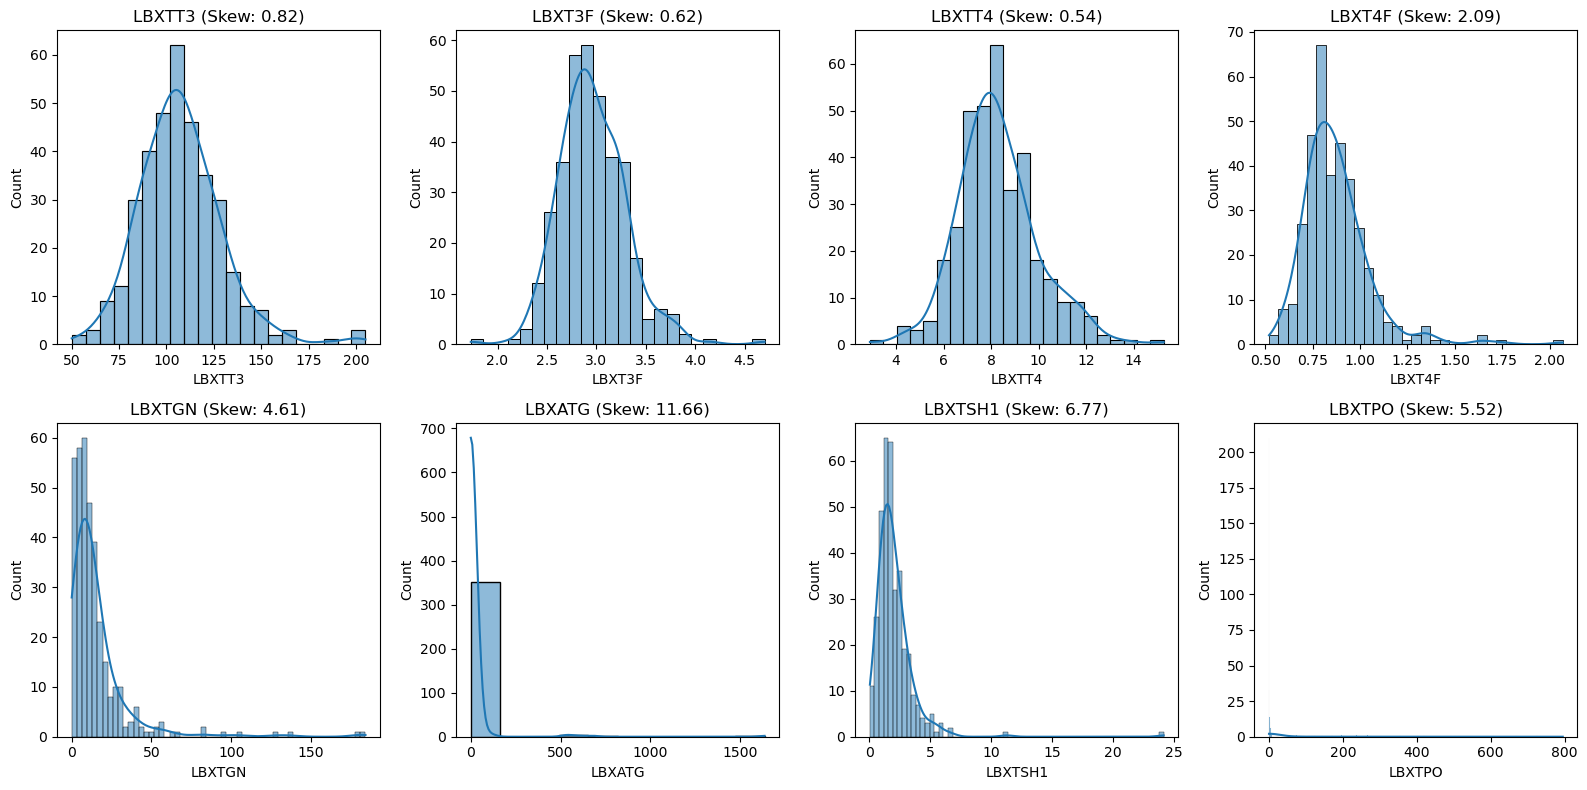

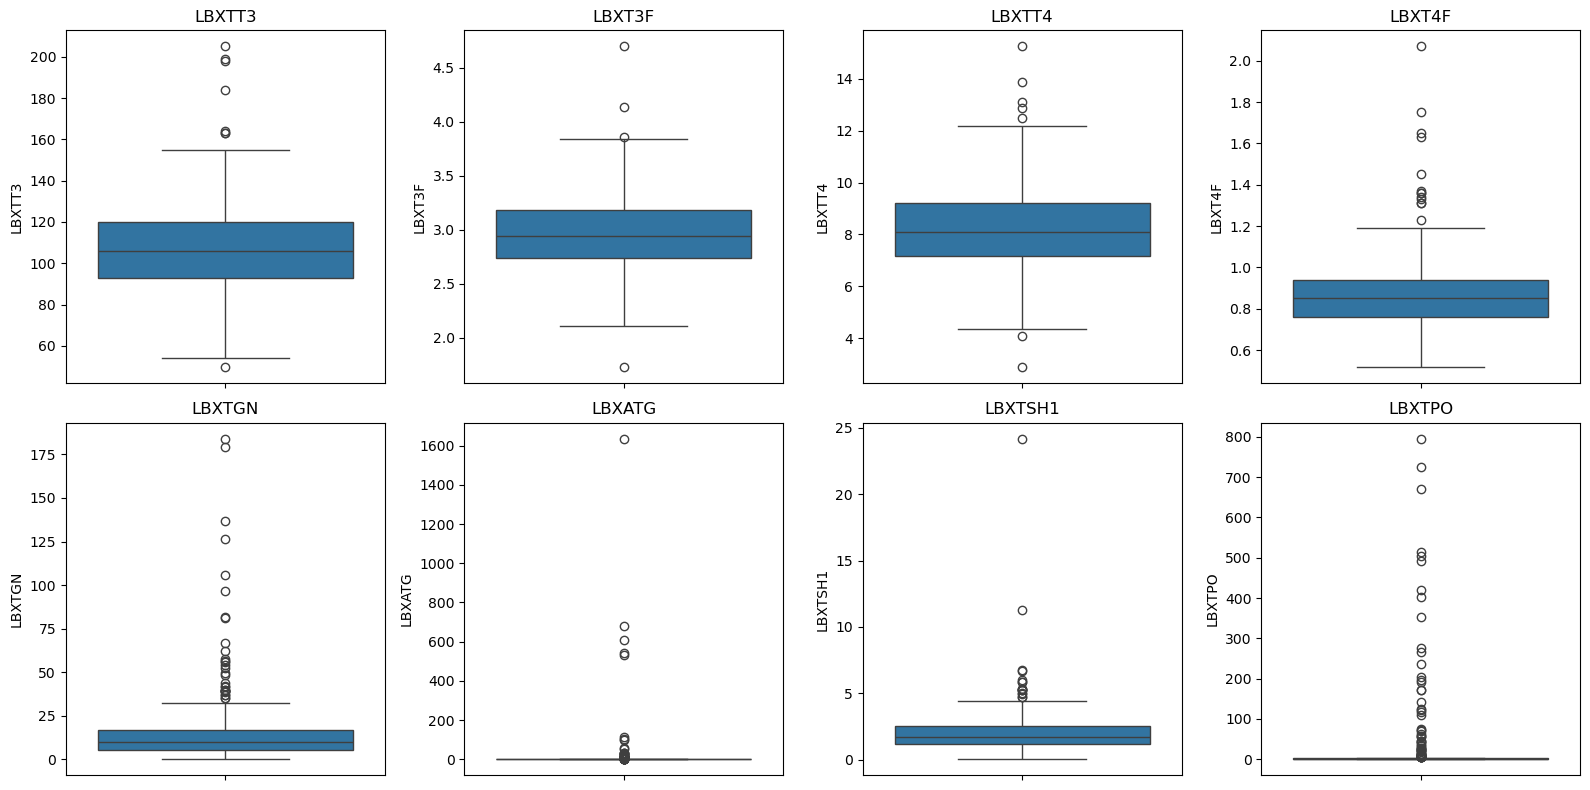

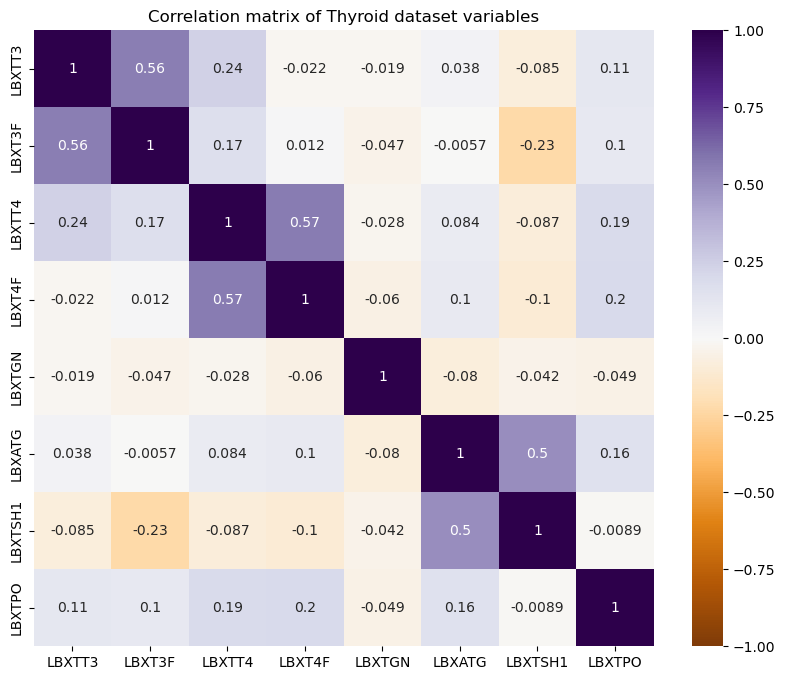

   feature        VIF
0   LBXTT3  39.818874
1   LBXT3F  59.869299
2   LBXTT4  41.400989
3   LBXT4F  34.895123
4   LBXTGN   1.530741
5   LBXATG   1.400407
6  LBXTSH1   2.969356
7   LBXTPO   1.136347


In [36]:
#List of the thyroid measures
thyroid_vars = ['LBXTT3', 'LBXT3F', 'LBXTT4', 'LBXT4F', 'LBXTGN', 'LBXATG', 'LBXTSH1', 'LBXTPO']
X = cog_lab_demo[thyroid_vars]

#Histogram distrinution
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, var in enumerate(thyroid_vars):
    ax = axes[i//4, i%4]
    sns.histplot(cog_lab_demo[var], kde=True, ax=ax)
    ax.set_title(f'{var} (Skew: {skew(cog_lab_demo[var]):.2f})')
plt.tight_layout()
plt.show()

#Boxplot of the outliars
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, var in enumerate(thyroid_vars):
    ax = axes[i//4, i%4]
    sns.boxplot(y=cog_lab_demo[var], ax=ax)
    ax.set_title(var)
plt.tight_layout()
plt.show()

#Correlation matrix of the biomarkers
corr_matrix = cog_lab_demo[thyroid_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='PuOr', vmin=-1, vmax=1)
plt.title('Correlation matrix of Thyroid dataset variables')
plt.show()


#Variance Inflation Factor (VIF) - to address multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = thyroid_vars
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(thyroid_vars))]
print(vif_data)



Transformed LBXTT3 with Box-Cox (New Skewness: 0.01)
Transformed LBXT3F with Box-Cox (New Skewness: -0.02)
Transformed LBXTT4 with Box-Cox (New Skewness: 0.02)
Transformed LBXT4F with Box-Cox (New Skewness: -0.05)
Transformed LBXTGN with Box-Cox (New Skewness: 0.01)
Transformed LBXATG with Box-Cox (New Skewness: 2.19)
Transformed LBXTSH1 with Box-Cox (New Skewness: -0.05)
Transformed LBXTPO with Box-Cox (New Skewness: 0.83)


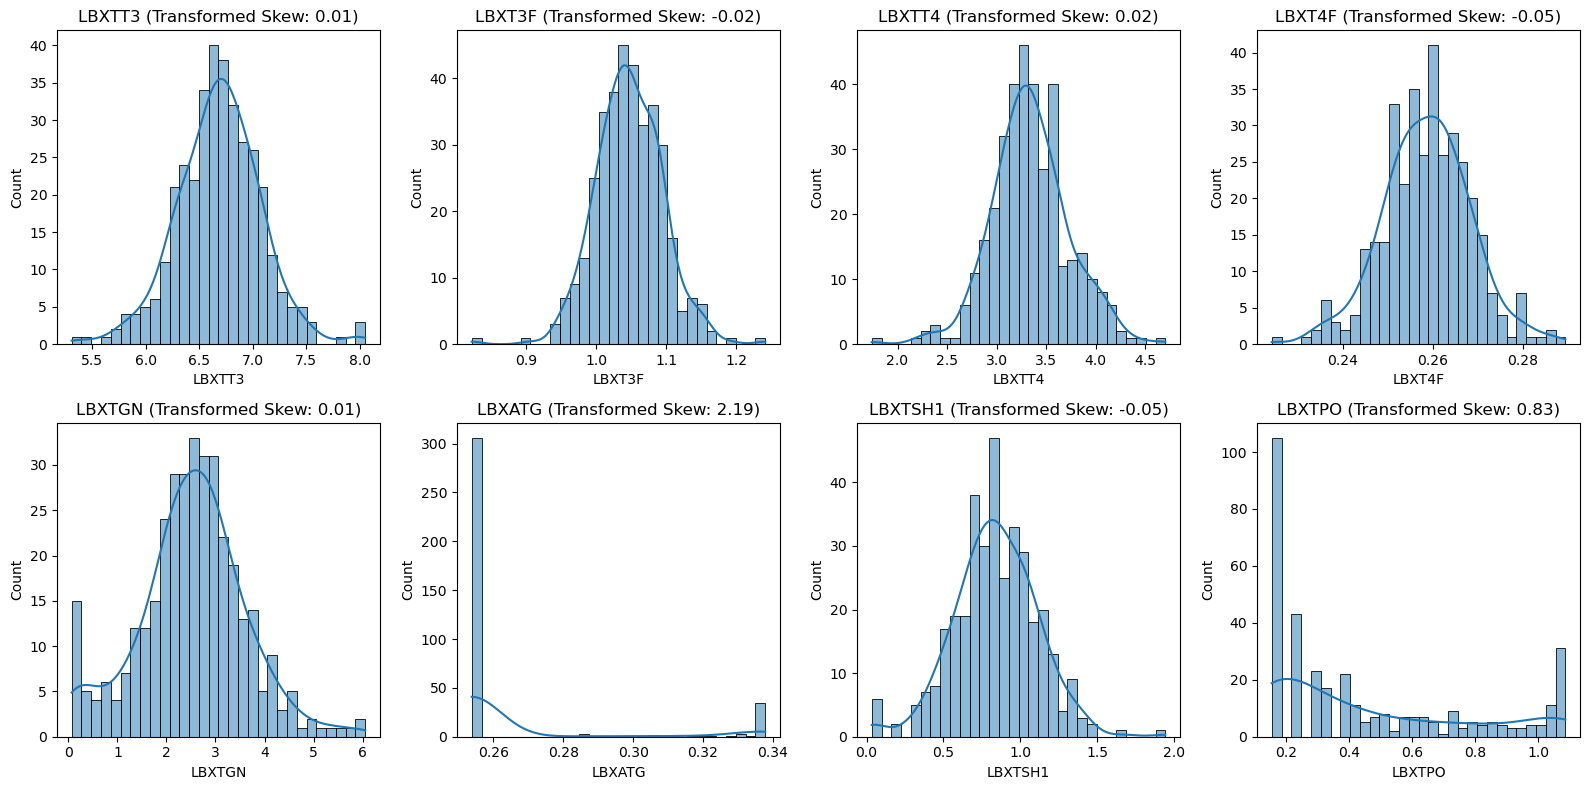

{'LBXTT3': 0.1456214363082333, 'LBXT3F': -0.4131686698877496, 'LBXTT4': 0.34708748389925337, 'LBXT4F': -3.375551570539223, 'LBXTGN': 0.05541482103752277, 'LBXATG': -2.960360916903441, 'LBXTSH1': -0.3465465838500582, 'LBXTPO': -0.9183998052428733}


In [37]:
#Perfroming the transformation if the variables on a copy to preserev the original data
transformed_data = cog_lab_demo.copy()

#Apply Box-Cox transformation (+1 constant to ensure positive results) 
# and saving the lambda parameter for future research/further actions (re-scaling back)
lambdas = {} 
for col in thyroid_vars:
    #
    transformed_data[col], lambdas[col] = boxcox(transformed_data[col] + 1)
    print(f"Transformed {col} with Box-Cox (New Skewness: {skew(transformed_data[col]):.2f})")

#A re-plot histogram distribution, now of the normalised biomarkers
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, col in enumerate(thyroid_vars):
    ax = axes[i // 4, i % 4]
    sns.histplot(transformed_data[col], kde=True, ax=ax, bins=30)
    ax.set_title(f"{col} (Transformed Skew: {skew(transformed_data[col]):.2f})")
    ax.set_xlabel(col)  

plt.tight_layout()
plt.show()

#for completeness purposes the lambdas are noted
print(lambdas)

In [38]:
# Separately adding that trasnformation to a _T verison of each variable in the dataset
lambdas = {}
for col in thyroid_vars:
    try:
        transformed_col, lambdas[col] = boxcox(cog_lab_demo[col] + 1)
        cog_lab_demo[f"{col}_T"] = transformed_col  #
    except Exception as e:
        print(f"Error transforming {col}: {e}")

#inspection to make sure we loaded the new columns correctly
print("Dataset shape:", cog_lab_demo.shape)
X = cog_lab_demo[[f"{col}_T" for col in thyroid_vars]]
print(X)

Dataset shape: (356, 41)
     LBXTT3_T  LBXT3F_T  LBXTT4_T  LBXT4F_T  LBXTGN_T  LBXATG_T  LBXTSH1_T  \
0    6.335120  0.992987  2.832628  0.250574  3.000562  0.253776   0.706949   
1    6.694028  1.015370  3.333621  0.260435  0.706631  0.332970   1.364928   
2    7.418943  1.081280  4.342604  0.274575  2.224844  0.253776   0.558383   
3    6.440622  1.013811  2.275483  0.224165  2.142087  0.253776   1.402849   
4    6.561072  1.049678  3.137086  0.248756  2.033831  0.253776   0.915948   
..        ...       ...       ...       ...       ...       ...        ...   
351  7.176002  1.130786  4.010844  0.270415  3.022885  0.253776   0.583848   
352  6.854456  1.018471  3.956159  0.261698  4.454955  0.253776   0.924939   
353  6.730648  1.004330  3.347721  0.260435  2.857399  0.253776   0.853309   
354  7.068355  1.134253  3.096807  0.246844  2.985942  0.253776   0.997379   
355  6.748744  1.056765  3.233198  0.257004  2.286614  0.253776   0.858406   

     LBXTPO_T  
0    0.925700  
1    1

In [39]:
#numerical descriptives 
descriptive_stats = {'Statistic': ['Mean', 'Median', 'Standard Deviation', 'Skewness', 'Kurtosis']}


for col in thyroid_vars:
    descriptive_stats[col] = [
        cog_lab_demo[col].mean(),
        cog_lab_demo[col].median(),
        cog_lab_demo[col].std(),
        skew(cog_lab_demo[col]),
        kurtosis(cog_lab_demo[col])]

#make a data frame
descriptive_table = pd.DataFrame(descriptive_stats).set_index('Statistic').T
print(descriptive_table)


Statistic        Mean  Median  Standard Deviation   Skewness    Kurtosis
LBXTT3     107.269663  106.00           21.733217   0.824852    2.426544
LBXT3F       2.961489    2.94            0.337336   0.615610    2.159589
LBXTT4       8.284073    8.08            1.677782   0.537486    1.097620
LBXT4F       0.871629    0.85            0.177230   2.086180    8.684858
LBXTGN      15.283904    9.81           20.891832   4.605886   28.017977
LBXATG      14.032303    0.60          106.922957  11.659526  156.434002
LBXTSH1      2.024382    1.72            1.721521   6.770912   77.708471
LBXTPO      23.744663    0.50           93.947690   5.523399   33.327056


Cognitive scores EDA

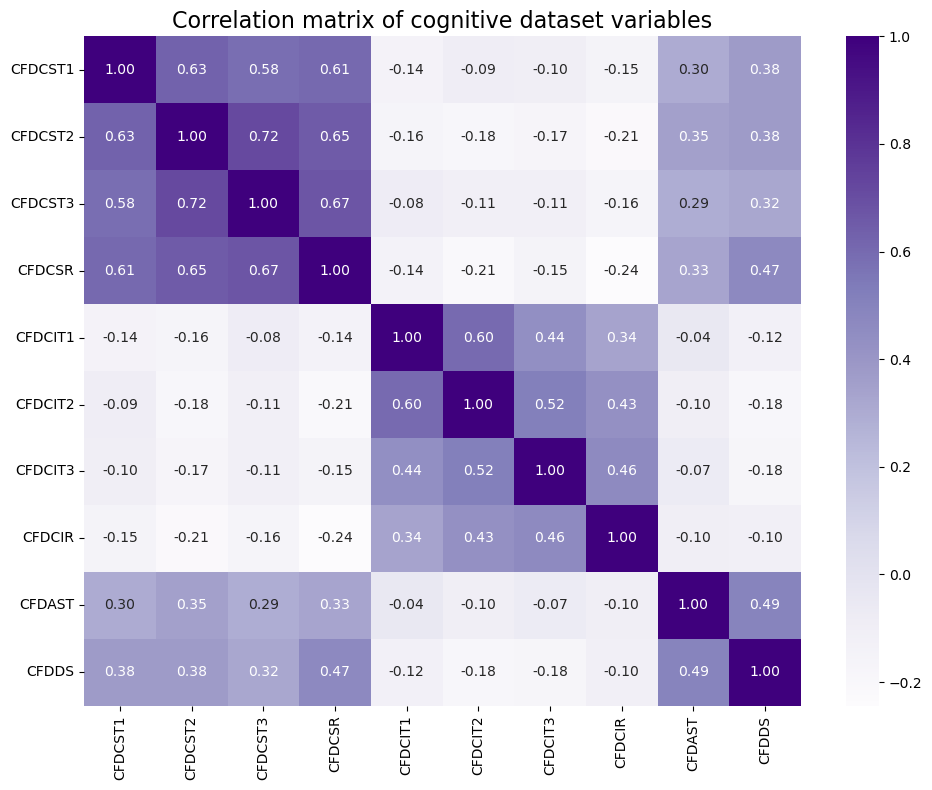

In [40]:
#listing the Cogntive variables
cognitive_vars = ['CFDCST1', 'CFDCST2', 'CFDCST3', 'CFDCSR', 'CFDCIT1', 'CFDCIT2', 'CFDCIT3', 'CFDCIR', 'CFDAST', 'CFDDS']

#Correlation matrix of the varaibles
correlation_matrix = cog_lab_demo[cognitive_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Purples', fmt='.2f', cbar=True)
plt.title('Correlation matrix of cognitive dataset variables', fontsize=16)

plt.tight_layout()
plt.show()


Explained variance ratios for PCA with ontrusion:
Component 1: 0.3781
Component 2: 0.2075
Component 3: 0.1009
Component 4: 0.0711
Component 5: 0.0547
Component 6: 0.0489
Component 7: 0.0462
Component 8: 0.0354
Component 9: 0.0313
Component 10: 0.0259

Explained variance ratios for PCA with reduced set:
Component 1: 0.5740
Component 2: 0.1666
Component 3: 0.0876
Component 4: 0.0723
Component 5: 0.0549
Component 6: 0.0446


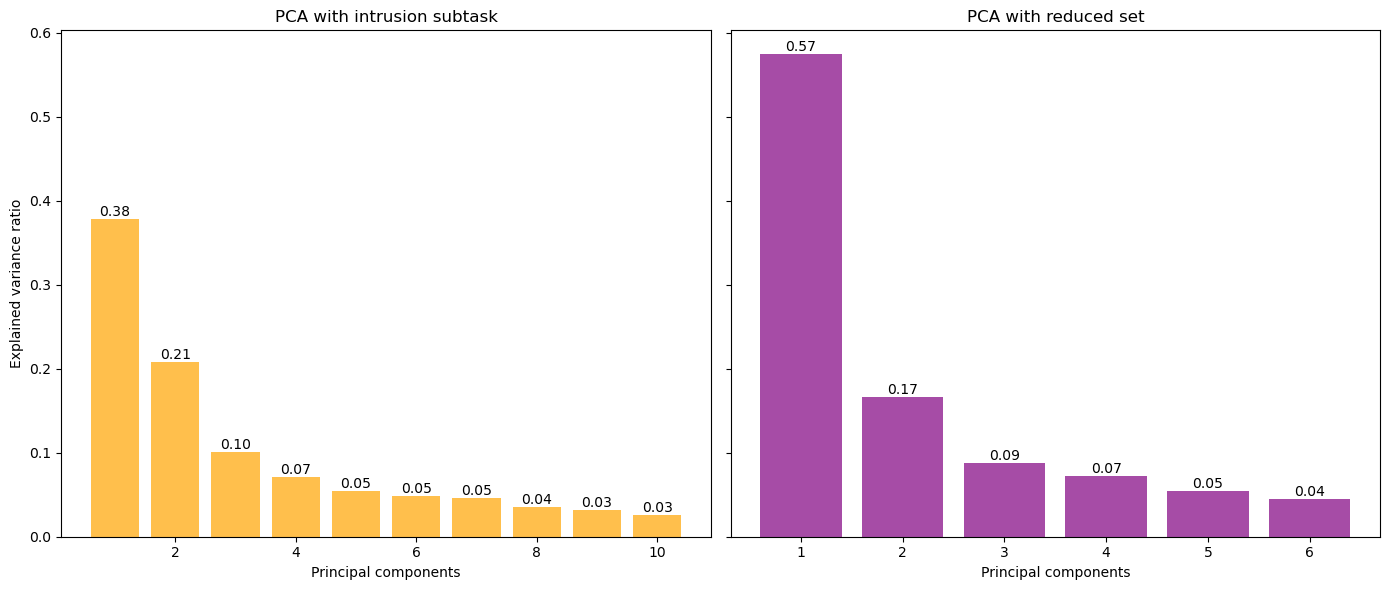

In [41]:
#PRINCIPLE COMPONENT ANALYSIS (PCA)

#Comparison of the frist component with and without intrusion word task included
cognitive_vars_with_intrusion = ['CFDCST1', 'CFDCST2', 'CFDCST3', 'CFDCSR', 'CFDCIT1', 'CFDCIT2', 'CFDCIT3', 'CFDCIR', 'CFDAST', 'CFDDS']
cognitive_vars = ['CFDCST1', 'CFDCST2', 'CFDCST3', 'CFDCSR', 'CFDAST', 'CFDDS']

#Apply PCA on the full score set
scaler = StandardScaler()
scaled_data_with_intrusion = scaler.fit_transform(cog_lab_demo[cognitive_vars_with_intrusion])

pca_with_intrusion = PCA()
principal_components_with_intrusion = pca_with_intrusion.fit_transform(scaled_data_with_intrusion)

#Apply PCA to reduced set
scaled_data = scaler.fit_transform(cog_lab_demo[cognitive_vars])

pca = PCA()
principal_components = pca.fit_transform(scaled_data)

#Numerical imspection of the comparison
print("Explained variance ratios for PCA with ontrusion:")
for i, ratio in enumerate(pca_with_intrusion.explained_variance_ratio_):
    print(f"Component {i+1}: {ratio:.4f}")

print("\nExplained variance ratios for PCA with reduced set:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"Component {i+1}: {ratio:.4f}")

#Histogram plot of the components to visualise the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

#Full set
axes[0].bar(range(1, len(pca_with_intrusion.explained_variance_ratio_) + 1),
            pca_with_intrusion.explained_variance_ratio_,
            color='orange', alpha=0.7)
axes[0].set_title("PCA with intrusion subtask")
axes[0].set_xlabel("Principal components")
axes[0].set_ylabel("Explained variance ratio")

for i, v in enumerate(pca_with_intrusion.explained_variance_ratio_):
    axes[0].text(i + 1, v, f"{v:.2f}", ha='center', va='bottom')

#Plot for the reduced one 
axes[1].bar(range(1, len(pca.explained_variance_ratio_) + 1),
            pca.explained_variance_ratio_,
            color='purple', alpha=0.7)
axes[1].set_title("PCA with reduced set")
axes[1].set_xlabel("Principal components")


for i, v in enumerate(pca.explained_variance_ratio_):
    axes[1].text(i + 1, v, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [42]:
#Extract the PC1 and create a new unified cognive score 
cog_lab_demo['Cognitive_Metric'] = principal_components[:, 0]

#Show the range of the new varaible Cognitive Metric
pc1_min = cog_lab_demo['Cognitive_Metric'].min()
pc1_max = cog_lab_demo['Cognitive_Metric'].max()

#make sure it refelcts teh reduced fit PC1
print("Variance Captured by PC1-Cognitive_Metric:", pca.explained_variance_ratio_[0])

#investigate its descriptives to gauge later performance interretation
mean_pc1 = cog_lab_demo['Cognitive_Metric'].mean()

below_mean_min = cog_lab_demo['Cognitive_Metric'][cog_lab_demo['Cognitive_Metric'] < mean_pc1].min()
below_mean_max = cog_lab_demo['Cognitive_Metric'][cog_lab_demo['Cognitive_Metric'] < mean_pc1].max()
below_mean_range = below_mean_max - below_mean_min

above_mean_min = cog_lab_demo['Cognitive_Metric'][cog_lab_demo['Cognitive_Metric'] >= mean_pc1].min()
above_mean_max = cog_lab_demo['Cognitive_Metric'][cog_lab_demo['Cognitive_Metric'] >= mean_pc1].max()
above_mean_range = above_mean_max - above_mean_min

print("Range of values below mean: Min =", below_mean_min, ", Max =", below_mean_max, ", Range =", below_mean_range)
print("Range of values above mean: Min =", above_mean_min, ", Max =", above_mean_max, ", Range =", above_mean_range)


#Above mean performance proprotion
mean_pc1 = cog_lab_demo['Cognitive_Metric'].mean()
above_mean_count = (cog_lab_demo['Cognitive_Metric'] > mean_pc1).sum()
total_count = len(cog_lab_demo['Cognitive_Metric'])

proportion_above_mean = above_mean_count / total_count
print(f"Proportion of values above the mean: {proportion_above_mean:.2f}")

if proportion_above_mean > 0.5:
    print("The majority of people have scores above the mean.")
else:
    print("The majority of people have scores below the mean.")

#Calculate mean of PC1 (near zero)
mean_pc1 = cog_lab_demo['Cognitive_Metric'].mean()
print(f"Mean of PC1: {mean_pc1}")

Variance Captured by PC1-Cognitive_Metric: 0.5739916386391404
Range of values below mean: Min = -3.9615606372562038 , Max = -0.015032950584424385 , Range = 3.9465276866717796
Range of values above mean: Min = 0.0019599485769069753 , Max = 5.876707783295797 , Range = 5.87474783471889
Proportion of values above the mean: 0.47
The majority of people have scores below the mean.
Mean of PC1: -3.4928364819667845e-17


In [43]:
print("Dataset shape:", cog_lab_demo.shape)


Dataset shape: (356, 42)


In [44]:
#prepatre dor the train-test Cross Validation splits
y = cog_lab_demo['Cognitive_Metric']

Demographics dataset EDA

In [45]:
#list the demographic varaibles
demographic_vars = ['RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'INDFMIN2', 'DMDFMSIZ']  


Skewness of age: 0.31969761057653545


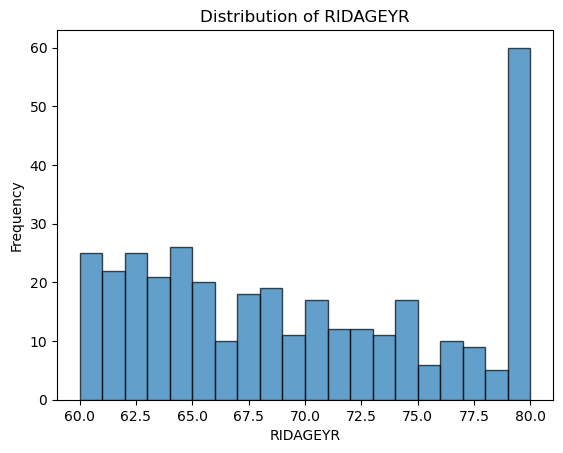

In [46]:
#all others are categorical and later one-hot encoded for ols so age is the only one I am plotting
#their frequencies can be inspected
#Skew of age to gauge if normalisation for the OLS is needed
age_skewness = skew(cog_lab_demo['RIDAGEYR'])
print(f'Skewness of age: {age_skewness}')

#Histogram distrinution plot of age
plt.hist(cog_lab_demo['RIDAGEYR'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('RIDAGEYR')
plt.ylabel('Frequency')
plt.title('Distribution of RIDAGEYR')
plt.show()


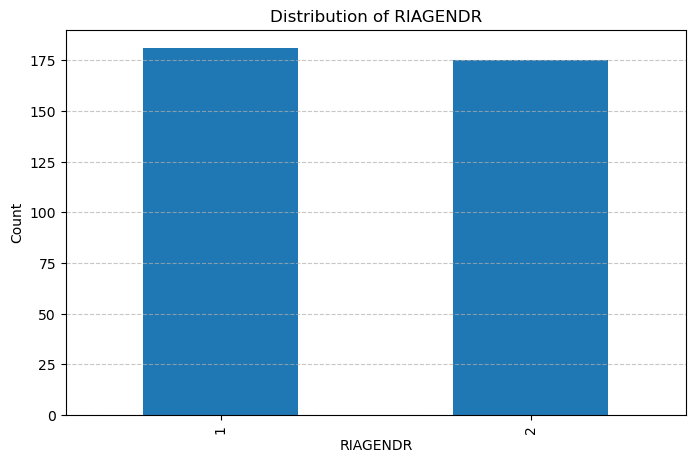

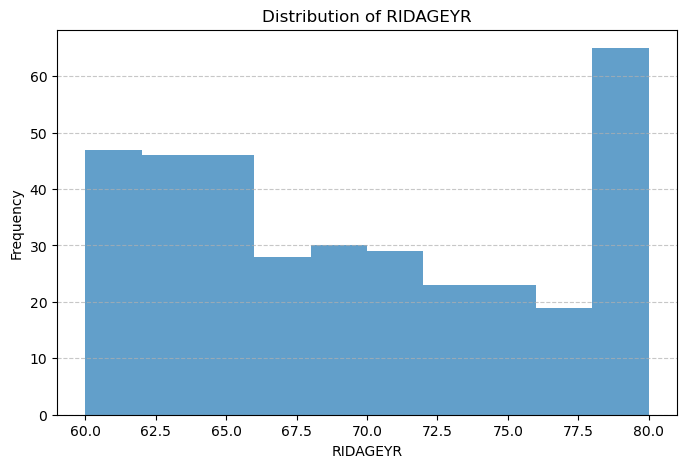

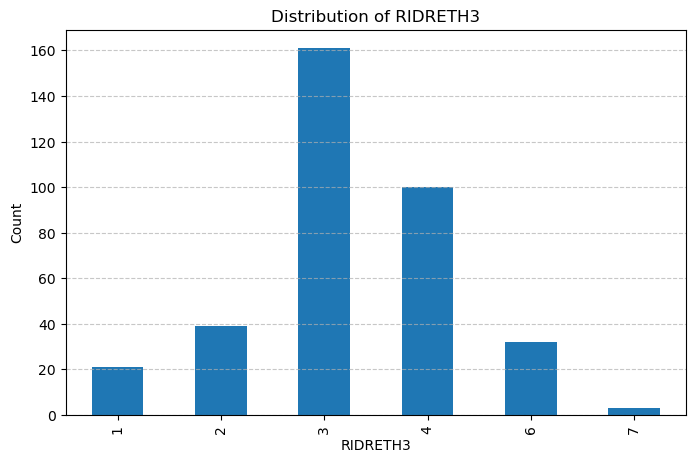

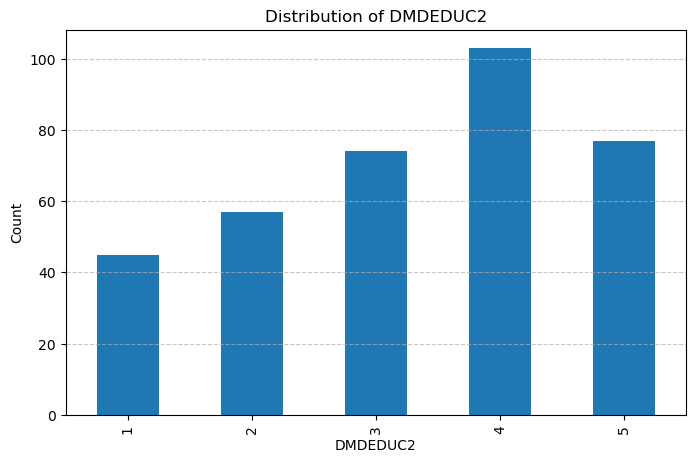

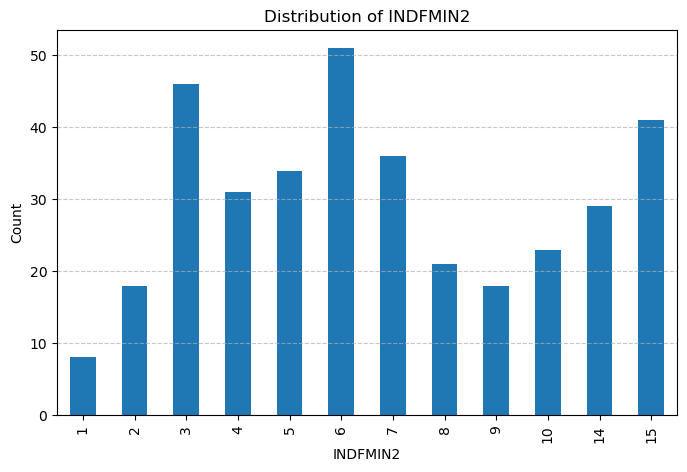

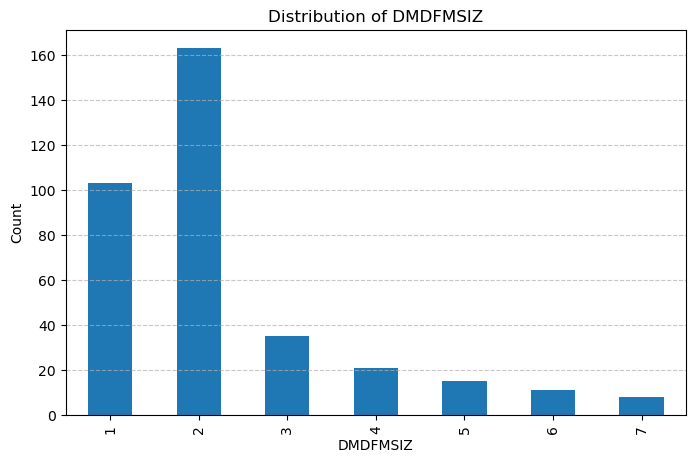

In [18]:

#demographic_vars = ['RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'INDFMIN2', 'DMDFMSIZ']

#Using the NHANES labels to map descriptions
demographic_labels = {
    'RIAGENDR': {1: 'Male', 2: 'Female'},
    'RIDRETH3': {
        1: 'Mexican American',
        2: 'Other Hispanic',
        3: 'Non-Hispanic White',
        4: 'Non-Hispanic Black',
        6: 'Non-Hispanic Asian',
        7: 'Other Race - Including Multi-Racial'
    },
    'DMDEDUC2': {
        1: 'Less than 9th grade',
        2: '9-11th grade (Includes 12th grade with no diploma)',
        3: 'High school graduate/GED or equivalent',
        4: 'Some college or AA degree',
        5: 'College graduate or above'
    },
    'INDFMIN2': {
        1: '$0 to $4,999',
        2: '$5,000 to $9,999',
        3: '$10,000 to $14,999',
        4: '$15,000 to $19,999',
        5: '$20,000 to $24,999',
        6: '$25,000 to $34,999',
        7: '$35,000 to $44,999',
        8: '$45,000 to $54,999',
        9: '$55,000 to $64,999',
        10: '$65,000 to $74,999',
        14: '$75,000 to $99,999',
        15: '$100,000 and Over'
    },
    'DMDFMSIZ': {
        1: '1 person',
        2: '2 people',
        3: '3 people',
        4: '4 people',
        5: '5 people',
        6: '6 people',
        7: '7 or more people'
    }
}

#Histogram plot for each varaible with its values sorted in asceding order
for var in demographic_vars:
    plt.figure(figsize=(8, 5))
    
    
    if cog_lab_demo[var].dtype == 'object' or cog_lab_demo[var].nunique() < 20:
        #put label is
        if var in demographic_labels:
            cog_lab_demo[var] = cog_lab_demo[var].map(demographic_labels[var])
        
        # Bar plot for categorical data
        if var == 'DMDEDUC2':
            cog_lab_demo[var].value_counts().reindex([demographic_labels[var][k] for k in sorted(demographic_labels[var].keys())]).plot(kind='bar')
        elif var == 'INDFMIN2':
            cog_lab_demo[var].value_counts().reindex([demographic_labels[var][k] for k in sorted(demographic_labels[var].keys())]).plot(kind='bar')
        else:
            cog_lab_demo[var].value_counts().sort_index().plot(kind='bar')
        
        plt.xlabel(var)
        plt.ylabel('Count')
        plt.title(f'Distribution of {var}')
        plt.xticks(rotation=45)
    else:
        # Custom binning for age variable
        if var == 'RIDAGEYR':
            age_range = range(60, 81)
            cog_lab_demo['RIDAGEYR_Binned'] = pd.cut(cog_lab_demo[var], bins=range(60, 82), labels=age_range, right=False)
            cog_lab_demo['RIDAGEYR_Binned'].value_counts().sort_index().plot(kind='bar')
            plt.xlabel('Age (Years)')
            plt.ylabel('Count')
            plt.title('Distribution of Age (60-80 Years)')
            plt.xticks(rotation=45)
        else:
            # Histogram for numerical data
            cog_lab_demo[var].plot(kind='hist', bins=10, alpha=0.7)
            plt.xlabel(var)
            plt.ylabel('Frequency')
            plt.title(f'Distribution of {var}')
            plt.xticks(rotation=45)
    
    plt.show()


# LINEAR REGRESSION

#### ONLY THYROID ON COG

In [19]:
#WITHOUT ALPHA OPTIMISATION

#Ridge L2-regularisation
ridge_model = Ridge(alpha=1.0)

#5 fold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=33)

#Cross validation of R^2 and MSE, negative scoring inversed afer
r2_scores = cross_val_score(ridge_model, X, y, cv=kfold, scoring='r2')
mse_scores = cross_val_score(ridge_model, X, y, cv=kfold, scoring='neg_mean_squared_error')
mse_scores = -mse_scores


#Overall perfromance assesment
y_pred_cv = cross_val_predict(ridge_model, X, y, cv=kfold)
overall_r2 = r2_score(y, y_pred_cv)
overall_mse = mean_squared_error(y, y_pred_cv)

#output scores
print("Cross-Validation Results (Ridge Regression):")
print(f"Average R² Score: {r2_scores.mean():.3f} (± {r2_scores.std():.3f})")
print(f"Average MSE: {mse_scores.mean():.3f} (± {mse_scores.std():.3f})")


print("\nOverall Metrics (Using Predictions Across All Folds):")
print(f"Overall R² Score: {overall_r2:.3f}")
print(f"Overall MSE: {overall_mse:.3f}")



Cross-Validation Results (Ridge Regression):
Average R² Score: 0.031 (± 0.042)
Average MSE: 3.327 (± 0.230)

Overall Metrics (Using Predictions Across All Folds):
Overall R² Score: 0.034
Overall MSE: 3.326


In [20]:
#WITH alpha parameter optimisation 

#range of alpha values to evaluate
alpha_grid = {'alpha': np.logspace(-4, 4, 50)}

#Ridge L2-regularisation
ridge_model = Ridge()

#5 fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=33)

#set grid search
grid_search = GridSearchCV(estimator=ridge_model, param_grid=alpha_grid, cv=kfold, scoring='r2', n_jobs=-1)
grid_search.fit(X, y)

#optimal aplha tuning
best_alpha = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {best_alpha}")

#evaluate optimised model
ridge_optimized = Ridge(alpha=best_alpha)

#R^2 and MSE calculation
r2_scores = cross_val_score(ridge_optimized, X, y, cv=kfold, scoring='r2')
mse_scores = cross_val_score(ridge_optimized, X, y, cv=kfold, scoring='neg_mean_squared_error')
mse_scores = -mse_scores


#Overall metrics on cross validated predictions
y_pred_cv = cross_val_predict(ridge_optimized, X, y, cv=kfold)
overall_r2 = r2_score(y, y_pred_cv)
overall_mse = mean_squared_error(y, y_pred_cv)
overall_rmse = np.sqrt(overall_mse)

#Output results
print("\nCross-Validation Results with Optimized Alpha:")
print(f"Average R² Score: {r2_scores.mean():.3f} (± {r2_scores.std():.3f})")
print(f"Average MSE: {mse_scores.mean():.3f} (± {mse_scores.std():.3f})")


print("\nOverall Metrics (Using Predictions Across All Folds):")
print(f"Overall R² Score: {overall_r2:.3f}")
print(f"Overall MSE: {overall_mse:.3f}")


Optimal Alpha: 7.9060432109076855

Cross-Validation Results with Optimized Alpha:
Average R² Score: 0.034 (± 0.035)
Average MSE: 3.318 (± 0.230)

Overall Metrics (Using Predictions Across All Folds):
Overall R² Score: 0.037
Overall MSE: 3.317


# RANDOM FOREST

In [21]:
#DEFAULT values for chosen parameters

#5 fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=33)

#set the defauklt valeus of the chosen set of parameters explicitly tomake sure 
random_forest_basic = RandomForestRegressor(
    n_estimators=100,       #numers of trees
    max_depth=None,         #maximum tree deth
    min_samples_split=2,    #nodes required for a split
    max_features='sqrt',    #maxium features
    random_state=33         #reproductability insuriance
)

#make sure the default values are as reported
print("\nExplicitly Set Hyperparameter Values:")
print(f"n_estimators: {random_forest_basic.get_params()['n_estimators']}")
print(f"max_depth: {random_forest_basic.get_params()['max_depth']}")
print(f"min_samples_split: {random_forest_basic.get_params()['min_samples_split']}")
print(f"max_features: {random_forest_basic.get_params()['max_features']}")

#Cross validate and compute R^2 and MSE
r2_scores_basic = cross_val_score(random_forest_basic, X, y, cv=kfold, scoring='r2')
mse_scores_basic = cross_val_score(random_forest_basic, X, y, cv=kfold, scoring='neg_mean_squared_error')

mse_scores_basic = -mse_scores_basic

#Overall metric coputed on the validated scores
y_pred_cv_basic = cross_val_predict(random_forest_basic, X, y, cv=kfold)
overall_r2_basic = r2_score(y, y_pred_cv_basic)
overall_mse_basic = mean_squared_error(y, y_pred_cv_basic)

# Fit the Random Forest on the entire dataset to extract feature importance (obsolete since best model was XGBoost)
#random_forest_basic.fit(X, y) 

# Print default model results
print("\nCross-Validation Results (Default Random Forest):")
print(f"Average R² Score: {r2_scores_basic.mean():.3f} (± {r2_scores_basic.std():.3f})")
print(f"Average MSE: {mse_scores_basic.mean():.3f} (± {mse_scores_basic.std():.3f})")

print("\nOverall Metrics (Using Predictions Across All Folds):")
print(f"Overall R² Score: {overall_r2_basic:.3f}")
print(f"Overall MSE: {overall_mse_basic:.3f}")



Explicitly Set Hyperparameter Values:
n_estimators: 100
max_depth: None
min_samples_split: 2
max_features: sqrt

Cross-Validation Results (Default Random Forest):
Average R² Score: 0.018 (± 0.030)
Average MSE: 3.375 (± 0.221)

Overall Metrics (Using Predictions Across All Folds):
Overall R² Score: 0.020
Overall MSE: 3.374


In [22]:
#WITH hyperparameter tuning
#defining the ggrid values
param_grid = {
    'n_estimators': [100, 200, 500],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'max_features': ['sqrt', 'log2']  
}

#set up Random Forest
random_forest_model = RandomForestRegressor(random_state=33)

#set up 5 fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=33)

#Cross validated grid search
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=kfold, scoring='r2', n_jobs=-1)
grid_search.fit(X, y)

#choosing and extracting the best hyperparameters 
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

#fitting the model with tuned values
best_random_forest = grid_search.best_estimator_

# cross validation on the optimised model
r2_scores = cross_val_score(best_random_forest, X, y, cv=kfold, scoring='r2')
mse_scores = cross_val_score(best_random_forest, X, y, cv=kfold, scoring='neg_mean_squared_error')

mse_scores = -mse_scores

#overall score based on CV
y_pred_cv = cross_val_predict(best_random_forest, X, y, cv=kfold)
overall_r2 = r2_score(y, y_pred_cv)
overall_mse = mean_squared_error(y, y_pred_cv)


#Output results
print("\nCross-Validation Results (Optimized Random Forest):")
print(f"Average R² Score: {r2_scores.mean():.3f} (± {r2_scores.std():.3f})")
print(f"Average MSE: {mse_scores.mean():.3f} (± {mse_scores.std():.3f})")


print("\nOverall Metrics (Using Predictions Across All Folds):")
print(f"Overall R² Score: {overall_r2:.3f}")
print(f"Overall MSE: {overall_mse:.3f}")


# Feature importance from the best model (not used since XGBoost outperfromed Random Forest) - 
#but can be run to show that the ranking of the top two features aligns
#feature_importances = best_random_forest.feature_importances_

# Create a DataFrame for feature importance
#importance_df = pd.DataFrame({
  #  'Feature': X.columns,
  #  'Importance': feature_importances
#}).sort_values(by='Importance', ascending=False)

#print("\nFeature Importance:")
#print(importance_df)


Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 200}

Cross-Validation Results (Optimized Random Forest):
Average R² Score: 0.027 (± 0.038)
Average MSE: 3.343 (± 0.239)

Overall Metrics (Using Predictions Across All Folds):
Overall R² Score: 0.029
Overall MSE: 3.342


# XGBOOST

In [23]:
#without hyperparameter tuning - basic model

#initialise explicitly with providing default values 
xgb_model_basic = XGBRegressor(
    colsample_bytree=1.0,       #amount of features used 
    learning_rate=0.3,          #shrinkage per step
    max_depth=6,                #maximum tree depth
    min_child_weight=1,         #minimum child weight
    n_estimators=100,           #amout of boosting rounds
    subsample=1.0,              #data used
    random_state=33             #insurance for reliable reprodutcion 
)

#set up 5-fold cross validation 
kfold = KFold(n_splits=5, shuffle=True, random_state=33)

#cross validate and estimate R^2 and MSE
r2_scores = cross_val_score(xgb_model_basic, X, y, cv=kfold, scoring='r2')
mse_scores = cross_val_score(xgb_model_basic, X, y, cv=kfold, scoring='neg_mean_squared_error')

mse_scores = -mse_scores

#overall scores based on CV
y_pred_cv = cross_val_predict(xgb_model_basic, X, y, cv=kfold)
overall_r2 = r2_score(y, y_pred_cv)
overall_mse = mean_squared_error(y, y_pred_cv)
overall_rmse = np.sqrt(overall_mse)

#Output results
print("\nCross-Validation Results (Default XGBoost):")
print(f"Average R² Score: {r2_scores.mean():.3f} (± {r2_scores.std():.3f})")
print(f"Average MSE: {mse_scores.mean():.3f} (± {mse_scores.std():.3f})")


print("\nOverall Metrics (Using Predictions Across All Folds):")
print(f"Overall R² Score: {overall_r2:.3f}")
print(f"Overall MSE: {overall_mse:.3f}")



Cross-Validation Results (Default XGBoost):
Average R² Score: -0.161 (± 0.092)
Average MSE: 3.980 (± 0.289)

Overall Metrics (Using Predictions Across All Folds):
Overall R² Score: -0.156
Overall MSE: 3.981


In [24]:
#WITH hyperparameter tuning - OPTIMISED MODEL
#hyperparameter grid range 
param_grid = {
    'n_estimators': [100, 200, 500],        
    'max_depth': [3, 5, 7],                
    'learning_rate': [0.01, 0.1, 0.3],    
    'subsample': [0.5, 0.75, 1.0],         
    'colsample_bytree': [0.5, 0.75, 1.0], 
    'min_child_weight': [1, 5, 10]         
}

#set up XGBoost
xgb_model = XGBRegressor(random_state=33)

#address the negative scoring externaly for readability
scoring = make_scorer(mean_squared_error, greater_is_better=False)

#Cross validated grid search applid
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring=scoring, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

#Extarct the best hyperparametrs
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_
print("\nBest Hyperparameters:", best_params)

#define the cross validation for performance assesmet 
kfold = KFold(n_splits=5, shuffle=True, random_state=33)

#Cross validated R^2 and MSE
r2_scores = cross_val_score(best_xgb_model, X, y, cv=kfold, scoring='r2')
mse_scores = cross_val_score(best_xgb_model, X, y, cv=kfold, scoring='neg_mean_squared_error')

mse_scores = -mse_scores

#overall score based on the CV
y_pred_cv = cross_val_predict(best_xgb_model, X, y, cv=kfold)
overall_r2 = r2_score(y, y_pred_cv)
overall_mse = mean_squared_error(y, y_pred_cv)
overall_rmse = np.sqrt(overall_mse)

#Output results
print("\nCross-Validation Results (Optimized XGBoost):")
print(f"Average R² Score: {r2_scores.mean():.3f} (± {r2_scores.std():.3f})")
print(f"Average MSE: {mse_scores.mean():.3f} (± {mse_scores.std():.3f})")


print("\nOverall Metrics (Using Predictions Across All Folds):")
print(f"Overall R² Score: {overall_r2:.3f}")
print(f"Overall MSE: {overall_mse:.3f}")


Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}

Cross-Validation Results (Optimized XGBoost):
Average R² Score: 0.042 (± 0.017)
Average MSE: 3.291 (± 0.185)

Overall Metrics (Using Predictions Across All Folds):
Overall R² Score: 0.044
Overall MSE: 3.291


In [25]:
#The best features are extracted
feature_importance = best_xgb_model.get_booster().get_score(importance_type='gain')

#converted to percentage for intuituve interpetation
total_importance = sum(feature_importance.values())
percent_importance = {k: (v / total_importance) * 100 for k, v in feature_importance.items()}

#numerical exploration of the ranking
sorted_percent_importance = {k: v for k, v in sorted(percent_importance.items(), key=lambda item: item[1], reverse=True)}
print("Feature Importance (% Contribution):")
for feature, importance in sorted_percent_importance.items():
    print(f"{feature}: {importance:.2f}%")


Feature Importance (% Contribution):
LBXTT3_T: 17.20%
LBXT3F_T: 15.48%
LBXTT4_T: 13.44%
LBXTSH1_T: 13.01%
LBXATG_T: 12.61%
LBXTGN_T: 10.80%
LBXTPO_T: 9.25%
LBXT4F_T: 8.21%


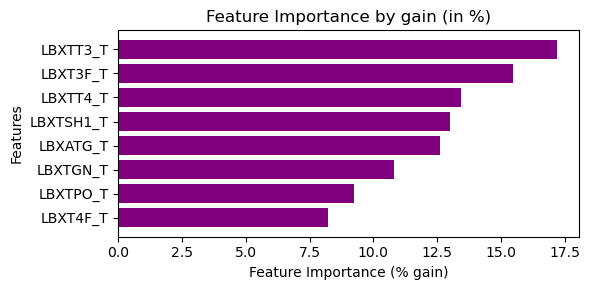

In [32]:


#extract for visualisation purposes
feature_importance = best_xgb_model.get_booster().get_score(importance_type='gain')

#convert to percentage
total_importance = sum(feature_importance.values())
percent_importance = {k: (v / total_importance) * 100 for k, v in feature_importance.items()}

#sort the contrinution
sorted_percent_importance = sorted(percent_importance.items(), key=lambda item: item[1], reverse=True)

#Visual inspetion - plot the ranking
features = [item[0] for item in sorted_percent_importance]
importance_values = [item[1] for item in sorted_percent_importance]

#visualise
plt.figure(figsize=(6, 3))
plt.barh(features, importance_values, color='purple')  
plt.xlabel('Feature Importance (% gain)')
plt.ylabel('Features')
plt.title('Feature Importance by gain (in %)')
#starting with most important at top, thus, reversed axis
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


Additional inspection post-hoc

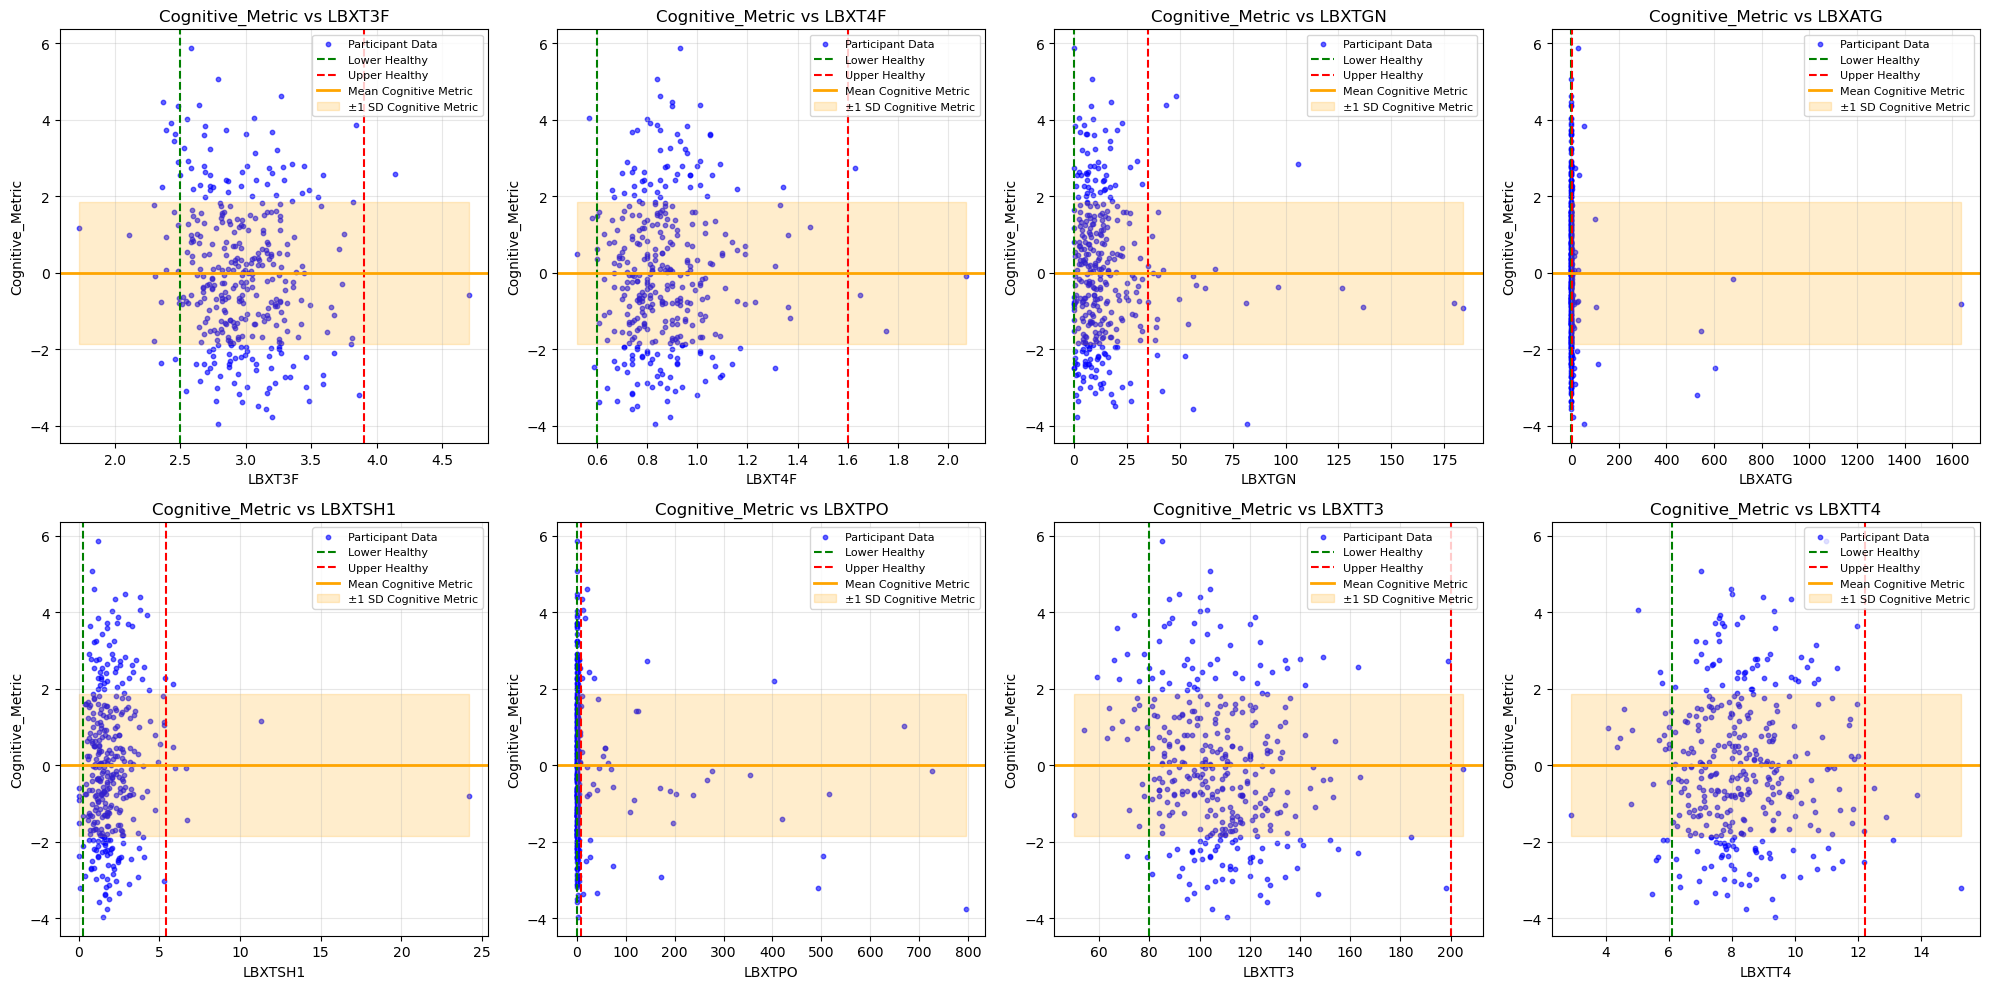

In [27]:
#Furtehr investigation of the possible noise

# Reference ranges for healthy individuals from NHANES Lab
thyroid_vars = {
    'LBXT3F': (2.5, 3.9),    #free triiodothyronine (fT3) (pg/mL)
    'LBXT4F': (0.6, 1.6),    #free thyroxine (fT4) (ng/dL)
    'LBXTGN': (0, 35.0),     #thyroglobulin (Tg) (ng/mL)
    'LBXATG': (0, 4.0),      #thyroglobulin antibody (TgAb) (IU/mL)
    'LBXTSH1': (0.24, 5.4),  #thyroid-stimulating hormone (TSH) (μIU/mL)
    'LBXTPO': (0, 9.0),      #thyroid peroxidase antibody (TPOAb) (IU/mL)
    'LBXTT3': (80, 200),     #total triiodothyronine (T3) (ng/dL)
    'LBXTT4': (6.09, 12.23)  #total thyroxine (T4) (μg/dL)
}
cognitive_metric = 'Cognitive_Metric'

#has been done prior but for self-sufficiency of the current code block re-calculated
cognitive_mean = cog_lab_demo[cognitive_metric].mean()
cognitive_std = cog_lab_demo[cognitive_metric].std()

#instantiate the plotting and set details
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

#for each variable - small plot
for idx, (var, (lower_bound, upper_bound)) in enumerate(thyroid_vars.items()):
    ax = axes[idx]
    
    #plot the scores
    ax.scatter(cog_lab_demo[var], cog_lab_demo[cognitive_metric], 
               alpha=0.6, s=10, color='blue', label='Participant Data')
    
    #apply NHANES threshold regerence ranges
    ax.axvline(x=lower_bound, color='green', linestyle='--', linewidth=1.5, label='Lower Healthy')
    ax.axvline(x=upper_bound, color='red', linestyle='--', linewidth=1.5, label='Upper Healthy')
    
    #plot cognitive metric mean to portrat (sub)optimal perfromance
    ax.axhline(y=cognitive_mean, color='orange', linestyle='-', linewidth=2, label='Mean Cognitive Metric')
    
    #indicate one standard deviation range
    ax.fill_betweenx(y=[cognitive_mean - cognitive_std, cognitive_mean + cognitive_std], 
                     x1=min(cog_lab_demo[var]), x2=max(cog_lab_demo[var]), 
                     color='orange', alpha=0.2, label='±1 SD Cognitive Metric')
    
    
    ax.set_title(f'{cognitive_metric} vs {var}', fontsize=12)
    ax.set_xlabel(var, fontsize=10)
    ax.set_ylabel(cognitive_metric, fontsize=10)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

#check to troubleshoot incorrect plotting, later became obsolete
if len(thyroid_vars) < len(axes):
    for i in range(len(thyroid_vars), len(axes)):
        fig.delaxes(axes[i])


plt.tight_layout()
plt.show()


OLS

                            OLS Regression Results                            
Dep. Variable:       Cognitive_Metric   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     2.854
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           7.49e-12
Time:                        16:58:24   Log-Likelihood:                -582.39
No. Observations:                 356   AIC:                             1381.
Df Residuals:                     248   BIC:                             1799.
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

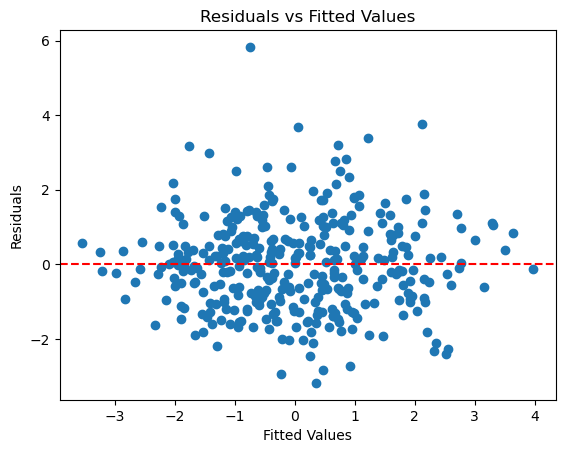

Breusch-Pagan p-value: 0.9971035152420472
No evidence of heteroscedasticity.
                                              Variable            VIF
0                                            Intercept  450160.157081
1       DMDEDUC2_Binned_High_School_or_College[T.True]    3264.951062
2               DMDEDUC2_Binned_No_High_School[T.True]    3758.289883
3                       DMDFMSIZ_Binned_Medium[T.True]   10717.456769
4                        DMDFMSIZ_Binned_Small[T.True]   14014.719273
..                                                 ...            ...
103  LBXTPO_T_RIDRETH3_Binned_Mexican_American_inte...       8.404120
104  LBXTPO_T_RIDRETH3_Binned_Other_Hispanic_intera...       8.751390
105         LBXTPO_T_RIDRETH3_Binned_White_interaction      11.370071
106                    LBXTPO_T_RIAGENDR_2_interaction       7.733328
107                      LBXTPO_T_RIDAGEYR_interaction     228.922165

[108 rows x 2 columns]
Variables with VIF > 10 may be suffering from multicollinea

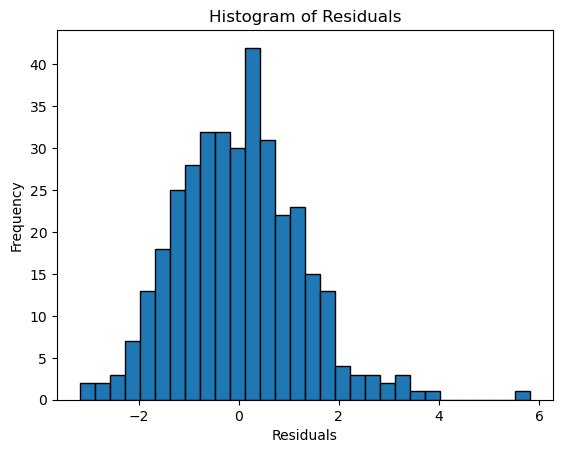

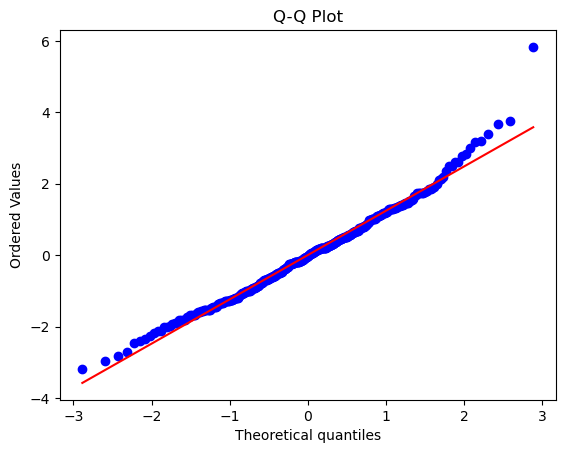

Shapiro-Wilk p-value: 0.000700838865425696
Residuals are not normally distributed.
Durbin-Watson Statistic: 2.009458356506072
No evidence of autocorrelation in residuals.


In [28]:
#for safety purposes work on copy of the
cog_lab_demo_copy = cog_lab_demo.copy()

#Re-establishing the bins in broader categories to reduce the aount of dummy varaibales, and thus, interaction terms
if 'DMDEDUC2' in cog_lab_demo_copy.columns:
    cog_lab_demo_copy = cog_lab_demo_copy[~cog_lab_demo_copy['DMDEDUC2'].isin([7, 9])]
    education_bins = {1: 'No_High_School', 2: 'High_School_or_College', 3: 'High_School_or_College', 
                      4: 'College_or_Advanced', 5: 'College_or_Advanced'}
    cog_lab_demo_copy['DMDEDUC2_Binned'] = cog_lab_demo_copy['DMDEDUC2'].map(education_bins)


if 'DMDFMSIZ' in cog_lab_demo_copy.columns:
    size_bins = {1: 'Small', 2: 'Small', 3: 'Medium', 4: 'Medium', 5: 'Large', 6: 'Large', 7: 'Large'}
    cog_lab_demo_copy['DMDFMSIZ_Binned'] = cog_lab_demo_copy['DMDFMSIZ'].map(size_bins)


if 'INDFMIN2' in cog_lab_demo_copy.columns:
    cog_lab_demo_copy = cog_lab_demo_copy[~cog_lab_demo_copy['INDFMIN2'].isin([12, 13])]
    income_bins = {1: 'Low_Income', 2: 'Low_Income', 3: 'Low_Income', 4: 'Low_Income',
                   5: 'Middle_Income', 6: 'Middle_Income', 7: 'Middle_Income',
                   8: 'Middle_Income', 9: 'Middle_Income',
                   10: 'High_Income', 14: 'High_Income', 15: 'High_Income'}
    cog_lab_demo_copy['INDFMIN2_Binned'] = cog_lab_demo_copy['INDFMIN2'].map(income_bins)


if 'RIDRETH3' in cog_lab_demo_copy.columns:
    race_bins = {1: 'Mexican_American', 2: 'Other_Hispanic', 3: 'White', 4: 'Black', 5: 'Other'}
    cog_lab_demo_copy['RIDRETH3_Binned'] = cog_lab_demo_copy['RIDRETH3'].map(race_bins)

#One-hot encoding the categorical variables
categorical_vars = ['RIAGENDR', 'DMDEDUC2_Binned', 'DMDFMSIZ_Binned', 'INDFMIN2_Binned', 'RIDRETH3_Binned']
cog_lab_demo_copy = pd.get_dummies(cog_lab_demo_copy, columns=categorical_vars, drop_first=True)

#calling teh transforemd thyroid scores
thyroid_vars = [col for col in cog_lab_demo_copy.columns if col.endswith('_T')]

# List of one-hot encoded demographic variables
demo_vars = [col for col in cog_lab_demo_copy.columns if 
             col.startswith('DMDEDUC2_Binned') or col.startswith('DMDFMSIZ_Binned') or 
             col.startswith('INDFMIN2_Binned') or col.startswith('RIDRETH3_Binned')]

#making sure all demographic variables are in, age is numerical
if 'RIAGENDR_2' in cog_lab_demo_copy.columns:
    demo_vars.append('RIAGENDR_2')
demo_vars.append('RIDAGEYR')

#check that the variables are either numerical or one-hot encoded for smooth OLS run
for demo in demo_vars:
    if not pd.api.types.is_numeric_dtype(cog_lab_demo_copy[demo]):
        print(f"Warning: {demo} is not numerical. Ensure it's properly one-hot encoded.")

#create interaction terms between the thyroid and the demographic varaibles
interaction_terms = []
for thyroid in thyroid_vars:
    for demo in demo_vars:
        interaction_term_name = f'{thyroid}_{demo}_interaction'
        cog_lab_demo_copy[interaction_term_name] = cog_lab_demo_copy[thyroid] * cog_lab_demo_copy[demo]
        interaction_terms.append(interaction_term_name)

#instantiate OLS model
all_vars = thyroid_vars + demo_vars + interaction_terms
formula = 'Cognitive_Metric ~ ' + ' + '.join(all_vars)

#fit the model
model = smf.ols(formula=formula, data=cog_lab_demo_copy).fit()

#output results
print(model.summary())


#Check assumptions for the OLS model
#libraries maintained since OLS was debeloped separately and loaded them with different notation, this is incosequential
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy import stats

#Linearity (residual plot  vs fit)
fitted_vals = model.fittedvalues
residuals = model.resid
plt.scatter(fitted_vals, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

#homoscedasticity (Breusch-Pagan test)
_, pval, __, f_pval = het_breuschpagan(model.resid, model.model.exog)
print('Breusch-Pagan p-value:', pval)
if pval < 0.05:
    print("Heteroscedasticity is present.")
else:
    print("No evidence of heteroscedasticity.")

#multicollinearity (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = model.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
print(vif_data)
print("Variables with VIF > 10 may be suffering from multicollinearity.")

#Normality of the residuals (Histogram plotm, Q-Q Plot, Shapiro-Wilk test)

plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)
if shapiro_test.pvalue < 0.05:
    print("Residuals are not normally distributed.")
else:
    print("Residuals appear normally distributed.")

#Independence of errors (Durbin-Watson test)
dw_statistic = sm.stats.durbin_watson(model.resid)
print("Durbin-Watson Statistic:", dw_statistic)
if 1.5 < dw_statistic < 2.5:
    print("No evidence of autocorrelation in residuals.")
else:
    print("Potential autocorrelation in residuals.")


In [29]:
#inspecting the numeric varaibles VIF to address multicollinearity

X = cog_lab_demo[['RIDAGEYR'] + thyroid_vars]
X['Intercept'] = 1  # Add constant for VIF calculation

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


    Variable          VIF
0   RIDAGEYR     1.134474
1   LBXTT3_T     1.801590
2   LBXT3F_T     1.627984
3   LBXTT4_T     1.769669
4   LBXT4F_T     1.750825
5   LBXTGN_T     1.184727
6   LBXATG_T     1.444146
7  LBXTSH1_T     1.159624
8   LBXTPO_T     1.267513
9  Intercept  2094.309913


/tmp/ipykernel_590/4199599483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Intercept'] = 1  # Add constant for VIF calculation


                            OLS Regression Results                            
Dep. Variable:       Cognitive_Metric   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     8.313
Date:                Mon, 02 Dec 2024   Prob (F-statistic):           5.00e-24
Time:                        16:58:38   Log-Likelihood:                -632.46
No. Observations:                 356   AIC:                             1321.
Df Residuals:                     328   BIC:                             1429.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

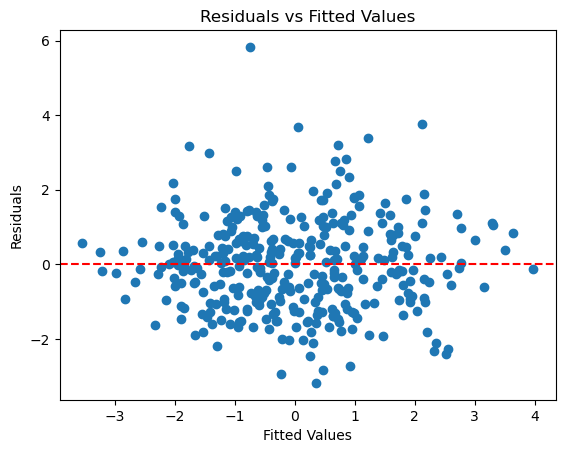

Breusch-Pagan p-value: 0.9971035152420472
No evidence of heteroscedasticity.
                                              Variable            VIF
0                                            Intercept  450160.157081
1       DMDEDUC2_Binned_High_School_or_College[T.True]    3264.951062
2               DMDEDUC2_Binned_No_High_School[T.True]    3758.289883
3                       DMDFMSIZ_Binned_Medium[T.True]   10717.456769
4                        DMDFMSIZ_Binned_Small[T.True]   14014.719273
..                                                 ...            ...
103  LBXTPO_T_RIDRETH3_Binned_Mexican_American_inte...       8.404120
104  LBXTPO_T_RIDRETH3_Binned_Other_Hispanic_intera...       8.751390
105         LBXTPO_T_RIDRETH3_Binned_White_interaction      11.370071
106                    LBXTPO_T_RIAGENDR_2_interaction       7.733328
107                      LBXTPO_T_RIDAGEYR_interaction     228.922165

[108 rows x 2 columns]
Variables with VIF > 10 may be suffering from multicollinea

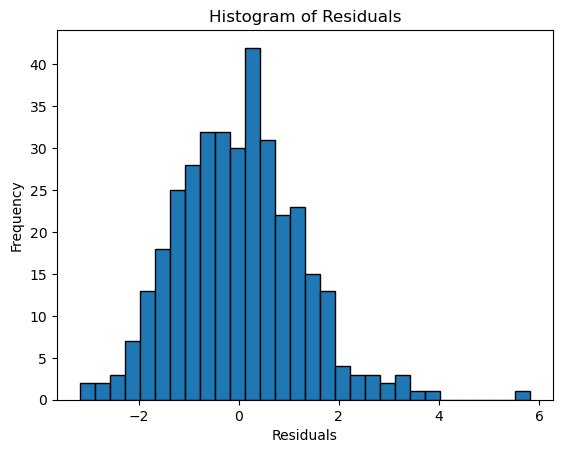

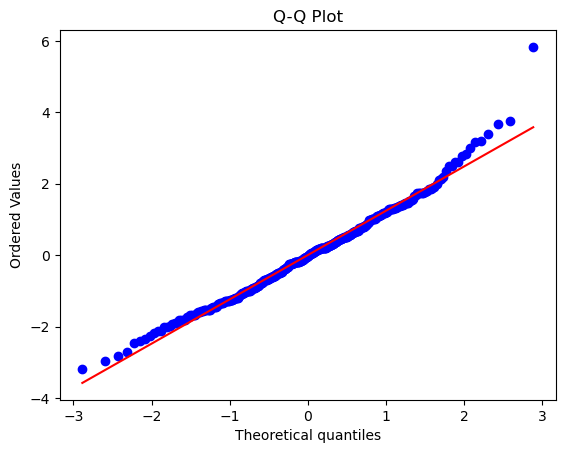

Shapiro-Wilk p-value: 0.000700838865425696
Residuals are not normally distributed.
Durbin-Watson Statistic: 2.009458356506072
No evidence of autocorrelation in residuals.


In [30]:
#after inspection, main effects, and terms with p<0.1 were preseved with quadreatic age added to address potential non-linearity

#updated formula
cog_lab_demo_copy['RIDAGEYR_Squared'] = cog_lab_demo_copy['RIDAGEYR'] ** 2
final_updated_formula_with_quadratic = '''
Cognitive_Metric ~ 
    RIAGENDR_2 + RIDAGEYR + RIDAGEYR_Squared + LBXTT3_T + LBXT3F_T +  LBXTT4_T + LBXT4F_T +
    LBXTGN_T + LBXATG_T + LBXTSH1_T + LBXTPO_T +
    LBXTT3_T_DMDFMSIZ_Binned_Small_interaction +
    LBXT3F_T_DMDEDUC2_Binned_No_High_School_interaction +
    LBXT3F_T_INDFMIN2_Binned_Middle_Income_interaction +
    LBXTGN_T_RIDRETH3_Binned_Other_Hispanic_interaction +
    LBXTSH1_T_INDFMIN2_Binned_Low_Income_interaction +
    LBXTSH1_T_RIAGENDR_2_interaction +
    LBXTPO_T_RIDAGEYR_interaction +
    DMDEDUC2_Binned_High_School_or_College +
    DMDEDUC2_Binned_No_High_School +
    DMDFMSIZ_Binned_Medium +
    DMDFMSIZ_Binned_Small +
    INDFMIN2_Binned_Low_Income +
    INDFMIN2_Binned_Middle_Income +
    RIDRETH3_Binned_Mexican_American +
    RIDRETH3_Binned_Other_Hispanic +
    RIDRETH3_Binned_White
'''

#fitting teh refined model
refined_model = smf.ols(formula=final_updated_formula_with_quadratic, data=cog_lab_demo_copy).fit()

#output of the refine OLS model
print(refined_model.summary())


#The same assumptions check follow
#Linearity
fitted_vals = model.fittedvalues
residuals = model.resid
plt.scatter(fitted_vals, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

#homoscedasticity
_, pval, __, f_pval = het_breuschpagan(model.resid, model.model.exog)
print('Breusch-Pagan p-value:', pval)
if pval < 0.05:
    print("Heteroscedasticity is present.")
else:
    print("No evidence of heteroscedasticity.")

#multicollinearity 
vif_data = pd.DataFrame()
vif_data["Variable"] = model.model.exog_names
vif_data["VIF"] = [variance_inflation_factor(model.model.exog, i) for i in range(model.model.exog.shape[1])]
print(vif_data)
print("Variables with VIF > 10 may be suffering from multicollinearity.")

#normality
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk p-value:", shapiro_test.pvalue)
if shapiro_test.pvalue < 0.05:
    print("Residuals are not normally distributed.")
else:
    print("Residuals appear normally distributed.")

#errors independence
dw_statistic = sm.stats.durbin_watson(model.resid)
print("Durbin-Watson Statistic:", dw_statistic)
if 1.5 < dw_statistic < 2.5:
    print("No evidence of autocorrelation in residuals.")
else:
    print("Potential autocorrelation in residuals.")
